# NYC Noise Analysis
## 1 Introduction
This is a Exploratory Data Analysis for 2015 New York City Noise Level Based on 311 Service Requests in all 5 boroughs of New York City. The results shown in this notebook will be used for building the TripElf interactive map application.

### 1.1 Load Librarys

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import geopandas, fiona
import pyproj    
import shapely
import shapely.ops as ops
from shapely.geometry import Point
from functools import partial

import matplotlib.colors as colors
import matplotlib.cm as cmx

### 1.2  Load Data

In [ ]:
df = pd.read_csv('/Users/Ada/Downloads/NYCnoise.csv', low_memory=False)

# keep 2015 record only
df = df[df['Created Date'].str.contains("2015")]


In [40]:
neighbourhoods_geo = geopandas.read_file("neighbourhoods.geojson")

neighbourhoods_nyc = pd.read_csv("neighbourhoods_nyc.csv", low_memory=False)

In [41]:
df = pd.read_csv('noise_neighborhood.csv', low_memory=False)

### 1.3 Preprocessing data

In [3]:
# run mapping function
def append_neighborhood(df, geo_df):
    # Create a list of Point objects
    point_list = []
    for idx, biz in df.iterrows():
        point_list.append(Point(biz["Longitude"], biz["Latitude"]))
    
    # Create a list of Polygon
    polygon_list = list(geo_df["geometry"])
    
    neighborhood_list = []
    neighborhood_group_list = []
    flag = True
    for i, point in enumerate(point_list):
        print(i, end='\r', flush=True)
        for j, polygon in enumerate(polygon_list):
            if point.within(polygon):
                neighborhood_list.append(neighbourhoods_geo.iloc[j][0])
                neighborhood_group_list.append(neighbourhoods_geo.iloc[j][1])
                break
            if j == len(polygon_list) - 1:
                neighborhood_list.append(None)
                neighborhood_group_list.append(None)
    
    df["neighborhood"] = neighborhood_list
    df["neighborhood_group"] = neighborhood_group_list
    df = df[~df["neighborhood"].isna()]
    return df

In [4]:
df = append_neighborhood(df, neighbourhoods_geo)

### 1.3 File structure and content

In [3]:
df.shape

(379649, 40)

In [4]:
df.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location,neighborhood,neighborhood_group
0,32218576,12/16/2015,12/18/2015,DEP,Department of Environmental Protection,Noise,Noise: air condition/ventilation equipment (NV1),NaN,11377.0,49-12 QUEENS BOULEVARD,...,NaN,NaN,NaN,NaN,NaN,40.742795,-73.915620,"(40.742794666185695, -73.91561976136614)",Sunnyside,Queens
1,32218591,12/16/2015,12/18/2015,DEP,Department of Environmental Protection,Noise,Noise: air condition/ventilation equipment (NV1),NaN,11204.0,7000 BAY PARKWAY,...,NaN,NaN,NaN,NaN,NaN,40.610927,-73.984477,"(40.61092717571984, -73.98447693156508)",Bensonhurst,Brooklyn
2,32218793,12/16/2015,12/16/2015,NYPD,New York City Police Department,Noise - Vehicle,Engine Idling,Street/Sidewalk,11201.0,CLINTON STREET,...,NaN,NaN,NaN,NaN,NaN,40.695539,-73.991810,"(40.69553857126335, -73.99181029552801)",Brooklyn Heights,Brooklyn
3,32219051,12/17/2015,12/17/2015,NYPD,New York City Police Department,Noise - Commercial,Banging/Pounding,Store/Commercial,11217.0,608 DEGRAW STREET,...,NaN,NaN,NaN,NaN,NaN,40.679294,-73.983780,"(40.67929416643323, -73.98377961007212)",Gowanus,Brooklyn
4,32219057,12/17/2015,12/18/2015,NYPD,New York City Police Department,Noise - Residential,Banging/Pounding,Residential Building/House,11226.0,75 MARTENSE STREET,...,NaN,NaN,NaN,NaN,NaN,40.651343,-73.956567,"(40.651342523766246, -73.95656673827526)",Flatbush,Brooklyn


### 1.4 Missing Values

In [5]:
df.isnull().sum()

Unique Key                             0
Created Date                           0
Closed Date                          428
Agency                                 0
Agency Name                            0
Complaint Type                         0
Descriptor                             0
Location Type                      56219
Incident Zip                          13
Incident Address                   43296
Street Name                        43296
Cross Street 1                     34595
Cross Street 2                     34774
Intersection Street 1             336565
Intersection Street 2             336565
Address Type                           0
City                                  10
Landmark                          379527
Facility Type                      57748
Status                                 0
Due Date                           56359
Resolution Action Updated Date       398
Community Board                        0
Borough                                0
X Coordinate (St

## 2 Individual feature visualizations
### 2.1 Categories & Count

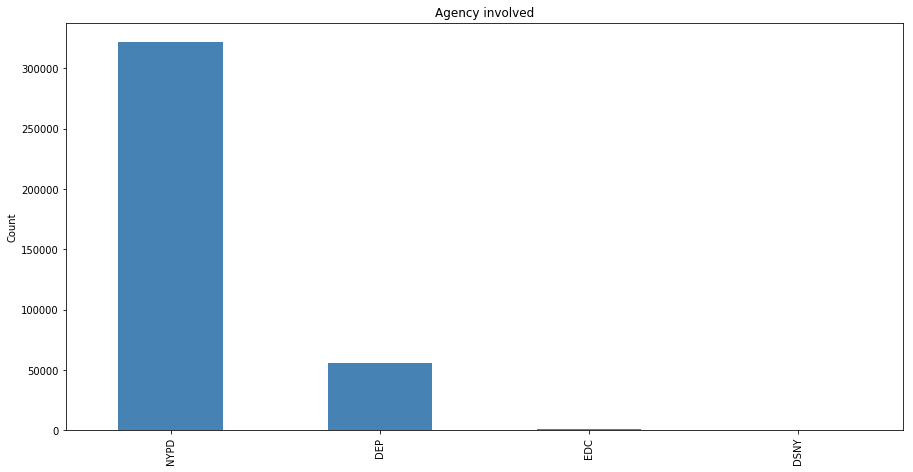

NYPD    321823
DEP      56183
EDC       1467
DSNY       176
Name: Agency, dtype: int64

In [6]:
# set default figure size
plt.rcParams['figure.figsize'] = (15.0, 7.5)

df['Agency'].value_counts().plot.bar(color='steelblue')
plt.ylabel('Count')
plt.title('Agency involved')
plt.show()
df['Agency'].value_counts()

In [7]:
df['Location Type'].value_counts()

Residential Building/House    204860
Street/Sidewalk                68830
Store/Commercial               22657
Club/Bar/Restaurant            20632
Park/Playground                 3750
Above Address                   1467
House of Worship                1058
Sidewalk                         176
Name: Location Type, dtype: int64

##### NYPD handles most cases. 

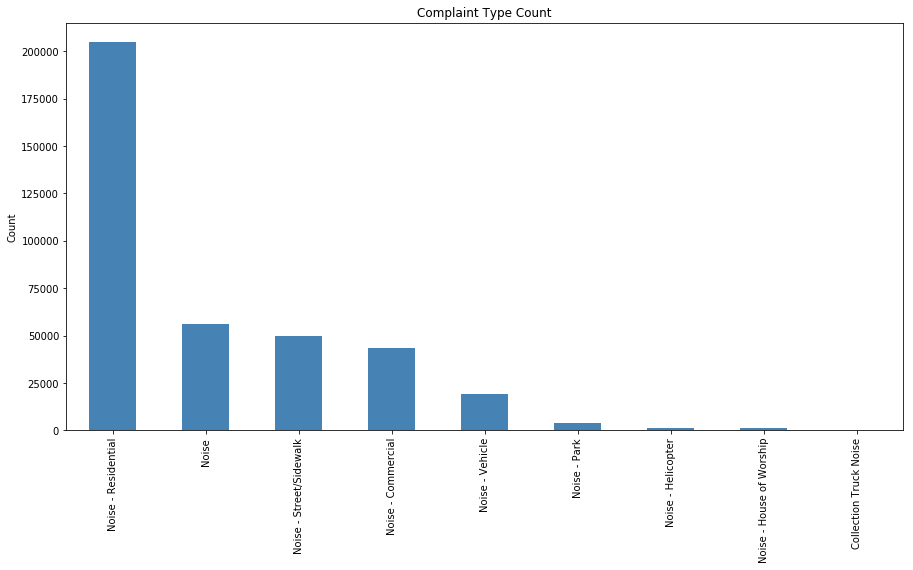

Noise - Residential         204876
Noise                        56183
Noise - Street/Sidewalk      49920
Noise - Commercial           43294
Noise - Vehicle              18922
Noise - Park                  3751
Noise - Helicopter            1467
Noise - House of Worship      1060
Collection Truck Noise         176
Name: Complaint Type, dtype: int64

In [8]:
df['Complaint Type'].value_counts().plot.bar(color='steelblue')
plt.ylabel('Complaint Type')
plt.ylabel('Count')
plt.title('Complaint Type Count')
plt.show()
df['Complaint Type'].value_counts()





##### The major source of noise is Residential.

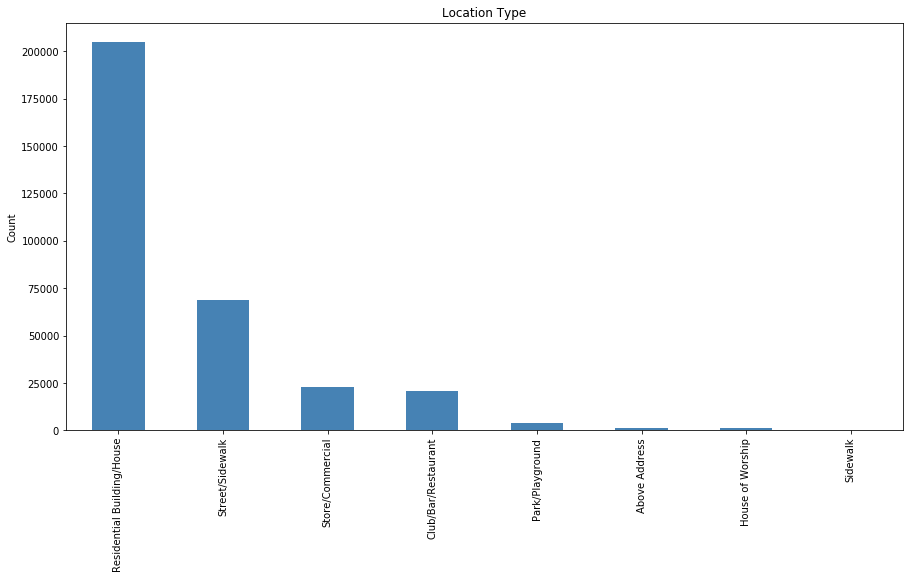

Residential Building/House    204860
Street/Sidewalk                68830
Store/Commercial               22657
Club/Bar/Restaurant            20632
Park/Playground                 3750
Above Address                   1467
House of Worship                1058
Sidewalk                         176
Name: Location Type, dtype: int64

In [9]:
df['Location Type'].value_counts().plot.bar(color='steelblue')
plt.ylabel('Count')
plt.title('Location Type')
plt.show()
df['Location Type'].value_counts()

##### Most cases heppened in Residential Building/House.

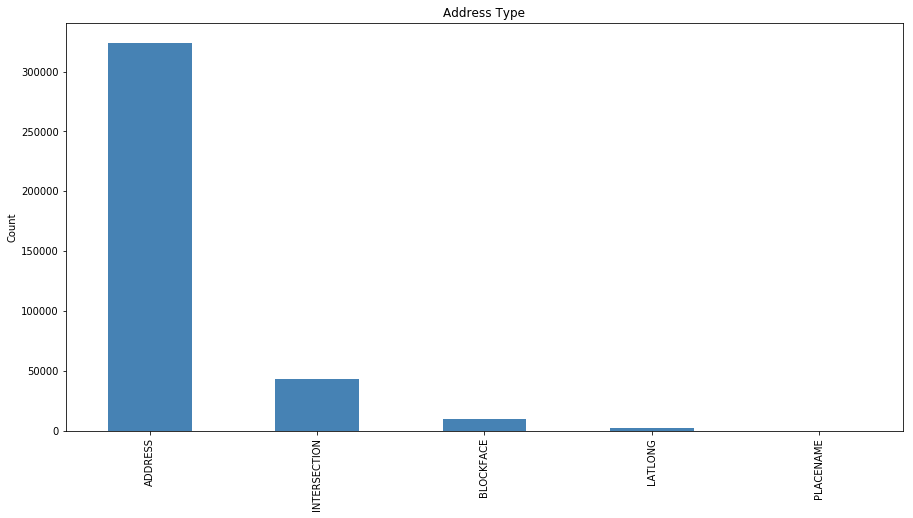

ADDRESS         324312
INTERSECTION     43067
BLOCKFACE         9754
LATLONG           2394
PLACENAME          122
Name: Address Type, dtype: int64

In [13]:
df['Address Type'].value_counts().plot.bar(color='steelblue')
plt.ylabel('Count')
plt.title('Address Type')
plt.show()
df['Address Type'].value_counts()

In [32]:
df1 = df['Location Type'].value_counts()
df1

Residential Building/House    204860
Street/Sidewalk                68830
Store/Commercial               22657
Club/Bar/Restaurant            20632
Park/Playground                 3750
Above Address                   1467
House of Worship                1058
Sidewalk                         176
Name: Location Type, dtype: int64

##### Most cases are reported with a specific address.

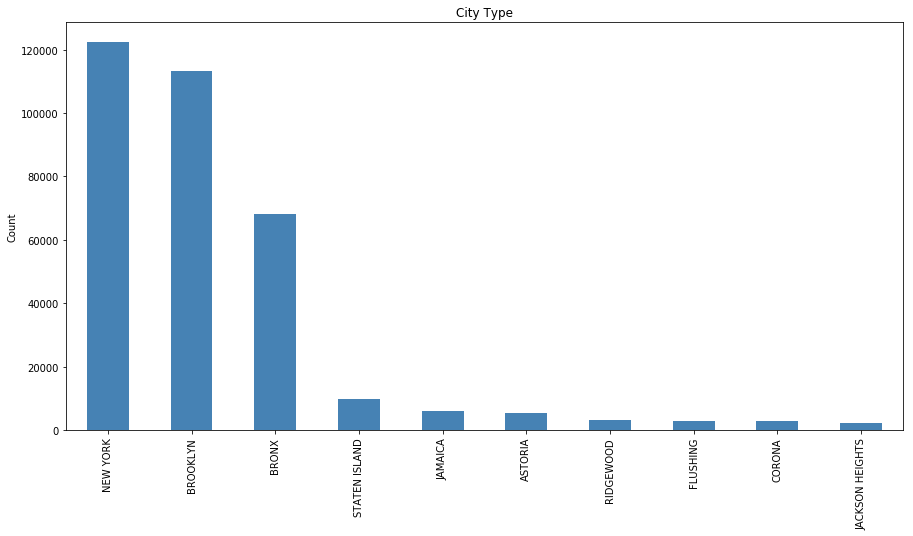

NEW YORK           122561
BROOKLYN           113297
BRONX               68089
STATEN ISLAND        9742
JAMAICA              5965
ASTORIA              5351
RIDGEWOOD            3137
FLUSHING             2937
CORONA               2807
JACKSON HEIGHTS      2332
Name: City, dtype: int64

In [14]:
df['City'].value_counts()[:10].plot.bar(color='steelblue')
plt.ylabel('Count')
plt.title('City Type')
plt.show()
df['City'].value_counts()[:10]

##### Most cases happened in city New York.

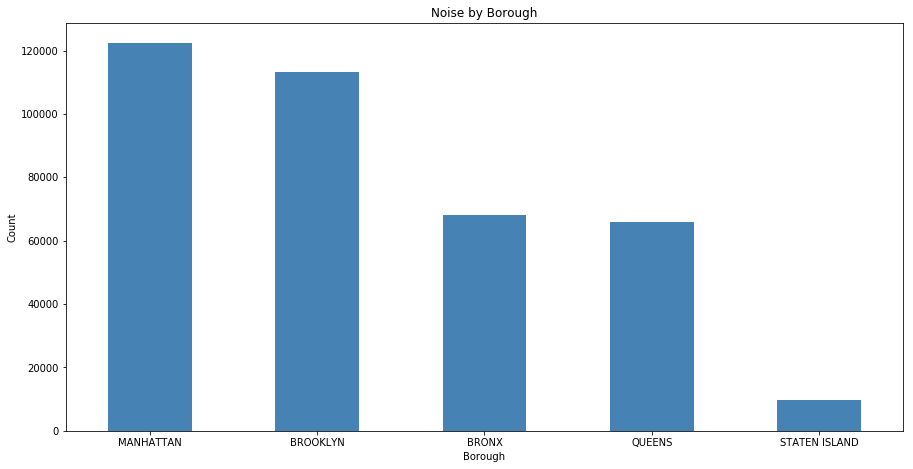

MANHATTAN        122573
BROOKLYN         113297
BRONX             68087
QUEENS            65950
STATEN ISLAND      9742
Name: Borough, dtype: int64

In [134]:
df['Borough'].value_counts().plot.bar(color = 'steelblue',rot = 0)
plt.ylabel('Count')
plt.xlabel('Borough')
plt.title('Noise by Borough')
plt.show()
df['Borough'].value_counts()

##### Most cases are reported in Manhattan.

### 2.2 Noise incident occurred time

In [14]:
df['Created Date'].describe()

count         379649
unique           365
top       05/10/2015
freq            2607
Name: Created Date, dtype: object

##### Most cases are reported on 5/10.

### 2.3 Lantitude&Longtitude


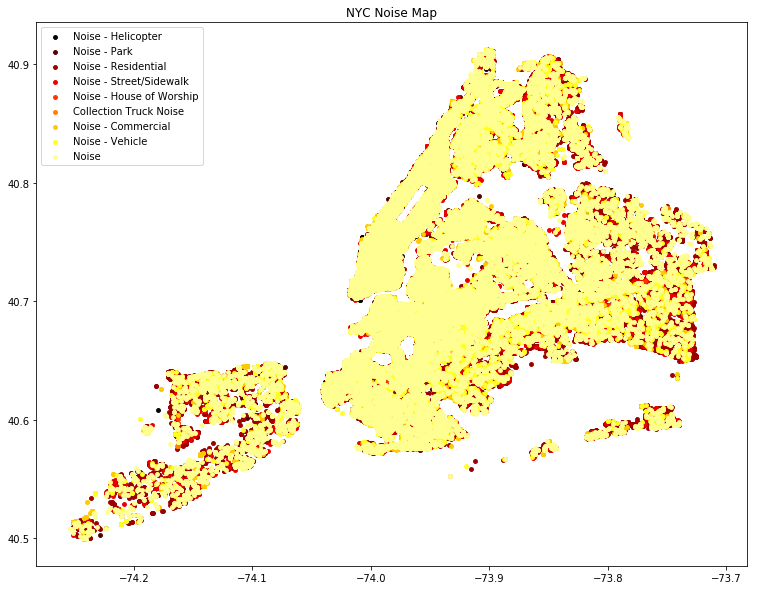

In [73]:
plt.figure(figsize=(20,10))

#Scatter of Petal
x=df['Longitude']
y=df['Latitude']

# Get unique names of complaint types
uniq = list(set(df['Complaint Type']))

# Set the color map to match the number of species
z = range(1,len(uniq))
hot = plt.get_cmap('hot')
cNorm  = colors.Normalize(vmin=0, vmax=len(uniq))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=hot)

# Plot each species
for i in range(len(uniq)):
    indx = df['Complaint Type'] == uniq[i]
    plt.scatter(x[indx], y[indx], s=15, color=scalarMap.to_rgba(i), label=uniq[i])
    
plt.gca().set_aspect('equal', adjustable='box')
plt.title('NYC Noise Map')
plt.legend(loc='upper left')
plt.show()

## 3 Feature relations with neightborhood
### 3.1 Count

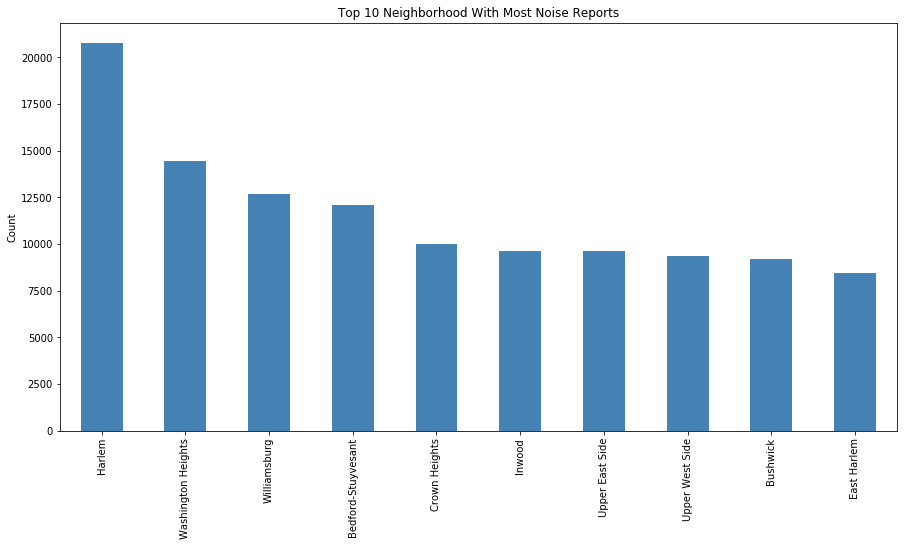

Harlem                20800
Washington Heights    14443
Williamsburg          12660
Bedford-Stuyvesant    12090
Crown Heights         10024
Inwood                 9653
Upper East Side        9653
Upper West Side        9340
Bushwick               9198
East Harlem            8477
Name: neighborhood, dtype: int64

In [86]:
df['neighborhood'].value_counts()[:10].plot.bar(color = 'steelblue')
plt.ylabel('Count')
plt.title('Top 10 Neighborhood With Most Noise Reports')
plt.show()
df['neighborhood'].value_counts()[:10]

##### Most cases are reported with neighborhood - Harlem.

###  3.2 Density

In [34]:
density_df = df.groupby(["neighborhood"]).agg({"Unique Key": "count"})\
    .join(neighbourhoods_nyc.set_index("neighbourhood"), on="neighborhood")
density_df['density'] = density_df["Unique Key"] / density_df["area"]
density_df.rename(columns={'Unique Key': 'count'},inplace=True)
density_df


,count,neighbourhood_group,area,centroid_longitude,centroid_latitude,density
neighborhood,,,,,,
Allerton,2233,Bronx,2.426870,-73.859984,40.864727,920.115131
Arden Heights,173,Staten Island,3.914071,-74.179461,40.554810,44.199508
Arrochar,331,Staten Island,2.072517,-74.072182,40.593187,159.709148
Arverne,201,Queens,1.983416,-73.795492,40.593379,101.340292
Astoria,5063,Queens,4.713354,-73.919746,40.765187,1074.181926
Bath Beach,604,Brooklyn,1.995924,-74.006610,40.603646,302.616700
Battery Park City,424,Manhattan,0.508072,-74.016084,40.711252,834.527749
Bay Ridge,1808,Brooklyn,3.637730,-74.028197,40.631071,497.013315
Bay Terrace,115,Queens,3.194219,-73.783137,40.784772,36.002540


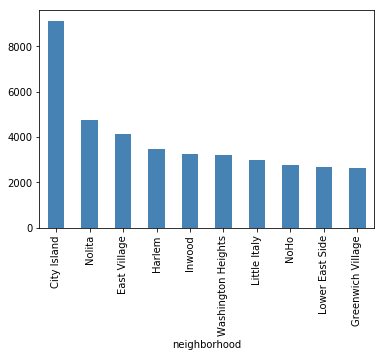

In [5]:
density_df = df.groupby(["neighborhood"]).agg({"Unique Key": "count"}) \
    .join(neighbourhoods_nyc.set_index("neighbourhood"), on="neighborhood")
density_df['density'] = density_df["Unique Key"] / density_df["area"]
density_df['density'].sort_values(ascending=False)[1:11].plot.bar(color='steelblue')
# density.sort_values(ascending=False)[1:11]
# density_df.head()

##### City Island is the neighborhood that has highest noise report density.

In [33]:
# output result
#df1 = df['neighborhood'].value_counts().reset_index(name = "count")
df1 = df.groupby(["neighborhood"]).count()["Unique Key"].reset_index(name = "count")
pd.DataFrame(df1)
df1
df1.to_csv('noise_neighborhood_count',encoding='utf-8', index=False)

In [6]:
density_df = df.groupby(["neighborhood"]).agg({"Unique Key": "count"}) \
    .join(neighbourhoods_nyc.set_index("neighbourhood"), on="neighborhood")
density_df['density'] = density_df["Unique Key"] / density_df["area"]

In [64]:
df.to_csv('noise_neighborhood',encoding='utf-8', index=False)

In [11]:
# gapminder_ocean.drop(['pop', 'gdpPercap', 'continent'], axis=1)

df.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location,neighborhood,neighborhood_group
0,32218576,12/16/2015,12/18/2015,DEP,Department of Environmental Protection,Noise,Noise: air condition/ventilation equipment (NV1),NaN,11377.0,49-12 QUEENS BOULEVARD,...,NaN,NaN,NaN,NaN,NaN,40.742795,-73.915620,"(40.742794666185695, -73.91561976136614)",Sunnyside,Queens
1,32218591,12/16/2015,12/18/2015,DEP,Department of Environmental Protection,Noise,Noise: air condition/ventilation equipment (NV1),NaN,11204.0,7000 BAY PARKWAY,...,NaN,NaN,NaN,NaN,NaN,40.610927,-73.984477,"(40.61092717571984, -73.98447693156508)",Bensonhurst,Brooklyn
2,32218793,12/16/2015,12/16/2015,NYPD,New York City Police Department,Noise - Vehicle,Engine Idling,Street/Sidewalk,11201.0,CLINTON STREET,...,NaN,NaN,NaN,NaN,NaN,40.695539,-73.991810,"(40.69553857126335, -73.99181029552801)",Brooklyn Heights,Brooklyn
3,32219051,12/17/2015,12/17/2015,NYPD,New York City Police Department,Noise - Commercial,Banging/Pounding,Store/Commercial,11217.0,608 DEGRAW STREET,...,NaN,NaN,NaN,NaN,NaN,40.679294,-73.983780,"(40.67929416643323, -73.98377961007212)",Gowanus,Brooklyn
4,32219057,12/17/2015,12/18/2015,NYPD,New York City Police Department,Noise - Residential,Banging/Pounding,Residential Building/House,11226.0,75 MARTENSE STREET,...,NaN,NaN,NaN,NaN,NaN,40.651343,-73.956567,"(40.651342523766246, -73.95656673827526)",Flatbush,Brooklyn


## Heatmap

In [ ]:
corr = car_data.loc[:,car_data.dtypes == 'float64'].corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=sns.diverging_palette(220, 10, as_cmap=True))

In [31]:
df1.head()

,neighborhood,count,neighbourhood_group,area,centroid_longitude,centroid_latitude
0,Allerton,2233,Bronx,2.426870,-73.859984,40.864727
1,Arden Heights,173,Staten Island,3.914071,-74.179461,40.554810
2,Arrochar,331,Staten Island,2.072517,-74.072182,40.593187
3,Arverne,201,Queens,1.983416,-73.795492,40.593379
4,Astoria,5063,Queens,4.713354,-73.919746,40.765187


Text(0.5, 1.0, 'Noise Complaint Count Frequency')

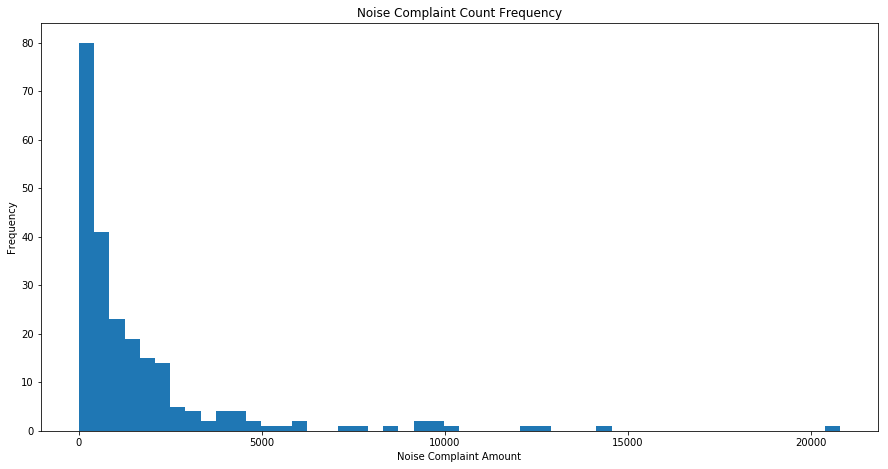

In [145]:
df1 = df.groupby(["neighborhood"]).count()["Unique Key"].reset_index(name = "count")
# df1.plot.hist()
plt.hist(df1['count'], bins=50)

plt.xlabel('Noise Complaint Amount')
plt.ylabel('Frequency')
plt.title('Noise Complaint Count Frequency')


In [28]:
density_df.columns
density_cor = density_df

In [ ]:
density_df.to_csv('noise_corr.',encoding='utf-8', index=False)


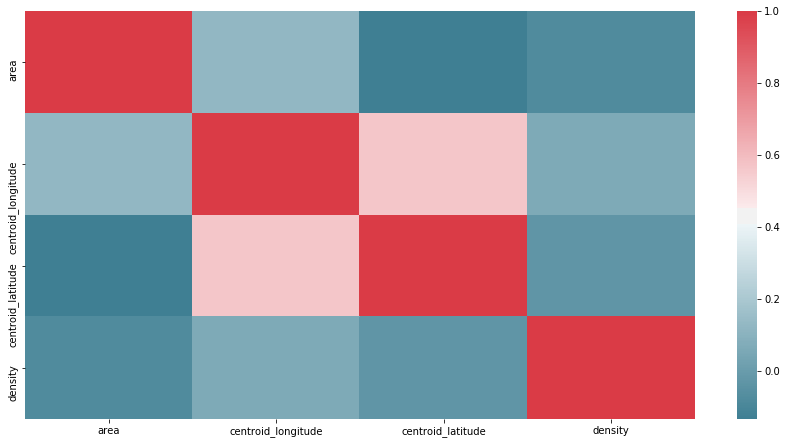

In [153]:
# Correlation map 
# nhbd, complaint type and zip
corr = density_df.loc[:,density_df.dtypes == 'float64'].corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=sns.diverging_palette(220, 10, as_cmap=True))

# Output

In [48]:
noise = pd.read_csv('noise_count.csv',  low_memory=False) 

,Unnamed: 0,neighbourhood,noise_count
0,0,Bayswater,276.0
1,1,Allerton,2233.0
2,2,City Island,250.0
3,3,Ditmars Steinway,1492.0
4,4,Ozone Park,2155.0
5,5,Fordham,5873.0
6,6,Whitestone,494.0
7,7,Arden Heights,173.0
8,8,Arrochar,331.0
9,9,Arverne,201.0


In [54]:
df['Complaint Type'].values

array(['Noise', 'Noise', 'Noise - Vehicle', ..., 'Noise',
       'Noise - Helicopter', 'Noise - Commercial'], dtype=object)

In [22]:

df3 = df.groupby('neighborhood')['Complaint Type'].value_counts().unstack().fillna(0)
pd.DataFrame(df3)
df3

Complaint Type,Collection Truck Noise,Noise,Noise - Commercial,Noise - Helicopter,Noise - House of Worship,Noise - Park,Noise - Residential,Noise - Street/Sidewalk,Noise - Vehicle
neighborhood,,,,,,,,,
Allerton,0.0,81.0,14.0,1.0,10.0,24.0,1880.0,176.0,47.0
Arden Heights,0.0,20.0,1.0,2.0,0.0,0.0,120.0,12.0,18.0
Arrochar,1.0,118.0,43.0,0.0,0.0,3.0,146.0,17.0,3.0
Arverne,0.0,22.0,2.0,1.0,2.0,2.0,139.0,26.0,7.0
Astoria,1.0,753.0,1589.0,22.0,20.0,36.0,2129.0,371.0,142.0
Bath Beach,1.0,127.0,26.0,2.0,4.0,9.0,334.0,58.0,43.0
Battery Park City,1.0,233.0,24.0,24.0,0.0,8.0,43.0,51.0,40.0
Bay Ridge,3.0,336.0,261.0,0.0,5.0,22.0,964.0,149.0,68.0
Bay Terrace,0.0,26.0,5.0,1.0,0.0,2.0,70.0,2.0,9.0


In [62]:
noise_output = pd.merge(noise, df3, how='left', left_on=['neighbourhood'], right_on=['neighborhood'])
noise_output = noise_output.drop(columns = ['Unnamed: 0'])
noise_output = noise_output.rename(columns={'noise_count': 'count'})
noise_output.fillna(0)
noise_output.to_csv('noise_complaint_type_count.csv',encoding='utf-8', index=False)
